In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam


2024-03-24 15:13:21.623294: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 15:13:21.623391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 15:13:21.749314: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
path = '/kaggle/input/finpros-data/'
files = os.listdir(path)
files

['FPT.csv', 'VIC.csv', 'PNJ.csv', 'MSN.csv']

In [3]:
df = pd.DataFrame()
for f in files:
    if f.endswith('.csv'):
        df = pd.concat([df, pd.read_csv(path + f)], axis = 0)

## khai phá dữ liệu

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 459335 entries, 0 to 135353
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         459335 non-null  object 
 1   Date/Time      459335 non-null  object 
 2   Open           459335 non-null  float64
 3   High           459335 non-null  float64
 4   Low            459335 non-null  float64
 5   Close          459335 non-null  float64
 6   Volume         459335 non-null  int64  
 7   Open Interest  459335 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 31.5+ MB


In [5]:
df.describe()

,Open,High,Low,Close,Volume,Open Interest
count,459335.000000,459335.000000,459335.000000,459335.000000,4.593350e+05,459335.0
mean,74.545826,74.626579,74.481065,74.546183,4.909390e+03,0.0
std,23.023346,23.038201,23.011619,23.024380,1.902104e+04,0.0
min,30.250000,30.250000,30.220000,30.250000,1.000000e+00,0.0
25%,54.190000,54.250000,54.150000,54.190000,3.600000e+02,0.0
50%,75.730000,75.920000,75.600000,75.720000,1.500000e+03,0.0
75%,90.100000,90.200000,90.000000,90.100000,4.920000e+03,0.0
max,126.100000,126.500000,126.100000,126.500000,3.300680e+06,0.0


In [6]:
df.isnull().sum()

Ticker           0
Date/Time        0
Open             0
High             0
Low              0
Close            0
Volume           0
Open Interest    0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
features = df.columns
for f in features:
    print(f, df[f].nunique())

Ticker 4
Date/Time 163177
Open 3761
High 3778
Low 3648
Close 3742
Volume 8932
Open Interest 1


In [9]:
df = df.drop(columns='Open Interest')
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume
0,FPT,2018-12-25 09:15:00,30.89,30.89,30.89,30.89,35410
1,FPT,2018-12-25 09:16:00,30.81,30.81,30.81,30.81,190
2,FPT,2018-12-25 09:17:00,30.74,30.81,30.74,30.74,1120
3,FPT,2018-12-25 09:18:00,30.74,30.74,30.74,30.74,2120
4,FPT,2018-12-25 09:19:00,30.74,30.74,30.74,30.74,22500


## giá cổ phiếu thay đổi

In [10]:
def price_change(df):
    df['Price Change'] = df['Close'] - df['Close'].shift(1)
    df.at[df.index[0], 'Price Change'] = 0
    return df

df = price_change(df)


In [11]:
df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Price Change
0,FPT,2018-12-25 09:15:00,30.89,30.89,30.89,30.89,35410,0.00
1,FPT,2018-12-25 09:16:00,30.81,30.81,30.81,30.81,190,-0.08
2,FPT,2018-12-25 09:17:00,30.74,30.81,30.74,30.74,1120,-0.07
3,FPT,2018-12-25 09:18:00,30.74,30.74,30.74,30.74,2120,0.00
4,FPT,2018-12-25 09:19:00,30.74,30.74,30.74,30.74,22500,0.00


## biểu đồ

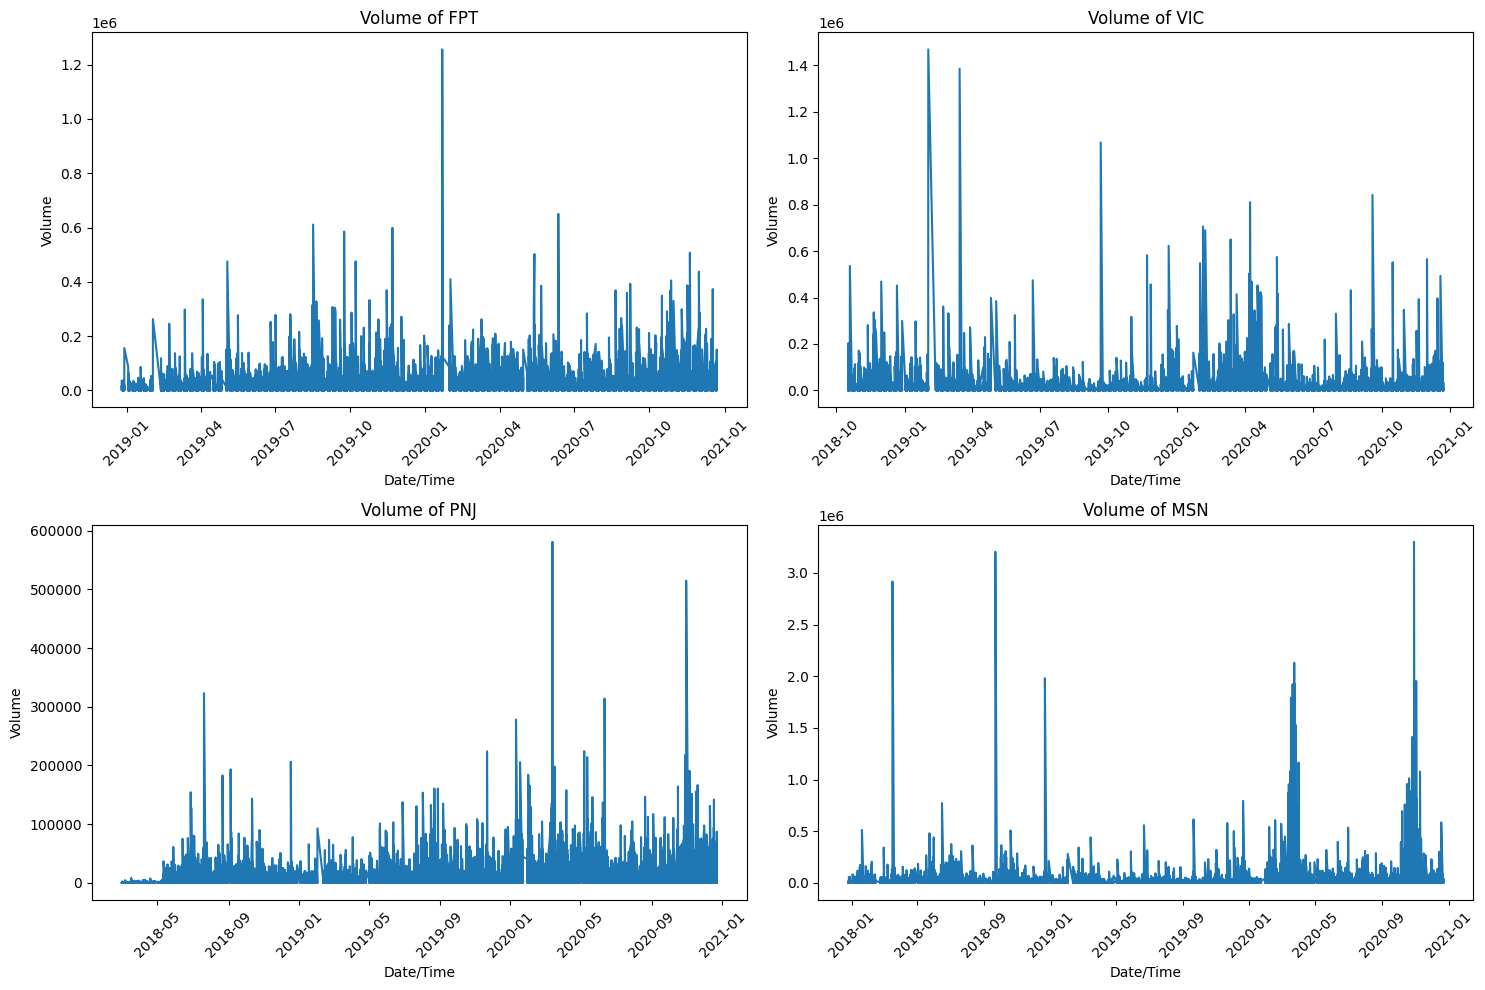

In [12]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, ticker in enumerate(df['Ticker'].unique()):
    df_ticker = df[df['Ticker'] == ticker]
    plt.subplot(2, 2, i+1)  # Tăng giá trị i lên 1
    plt.plot(df_ticker['Date/Time'], df_ticker['Volume'])
    plt.ylabel('Volume')
    plt.xlabel('Date/Time')
    plt.title(f"Volume of {ticker}")
    plt.xticks(rotation=45) 

plt.tight_layout()
plt.show()


* lượng mua vào của cổ phiếu FPT là ớn nhất nhìn chung lớn hơn so với 3 mã cổ phiếu còn lại

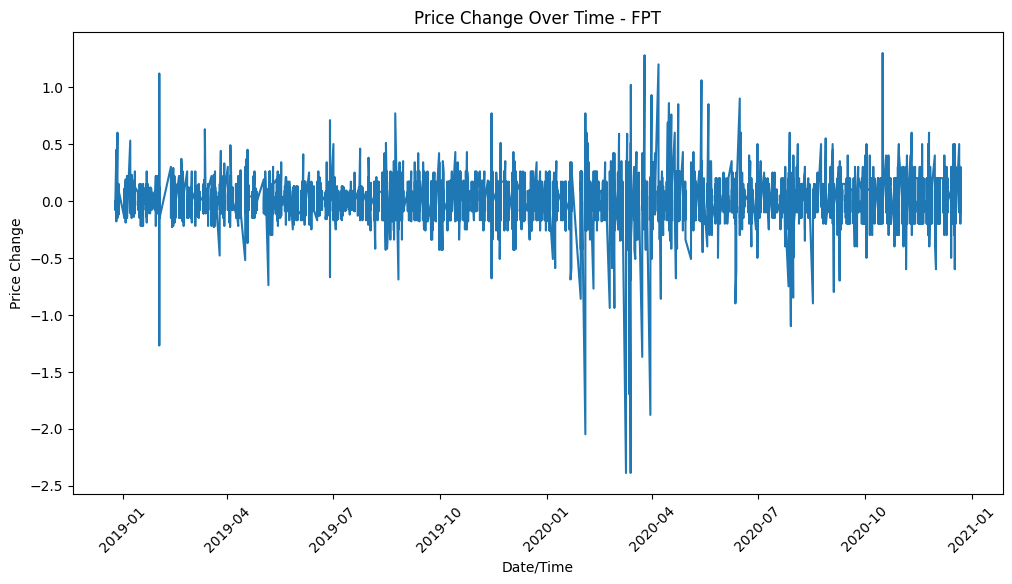

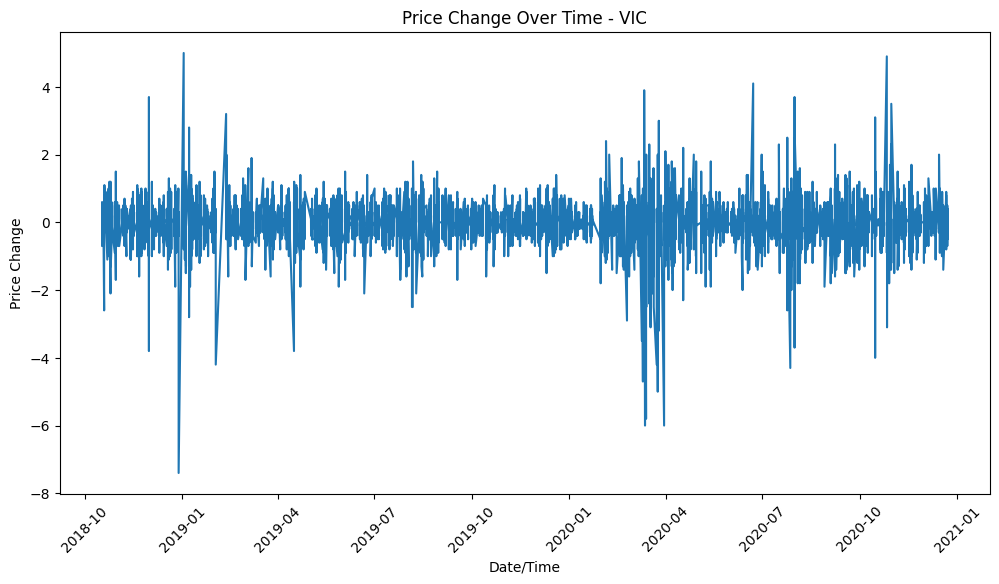

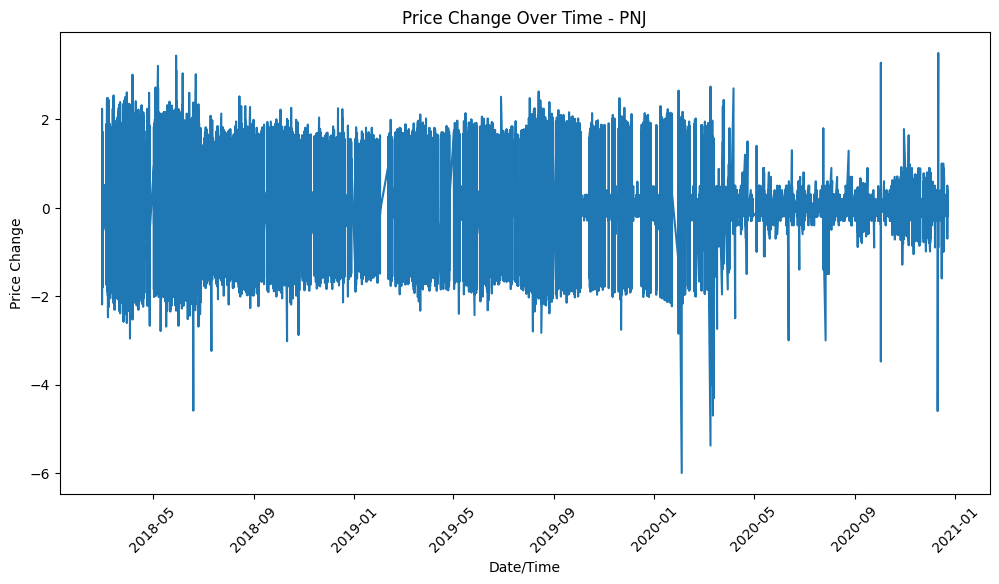

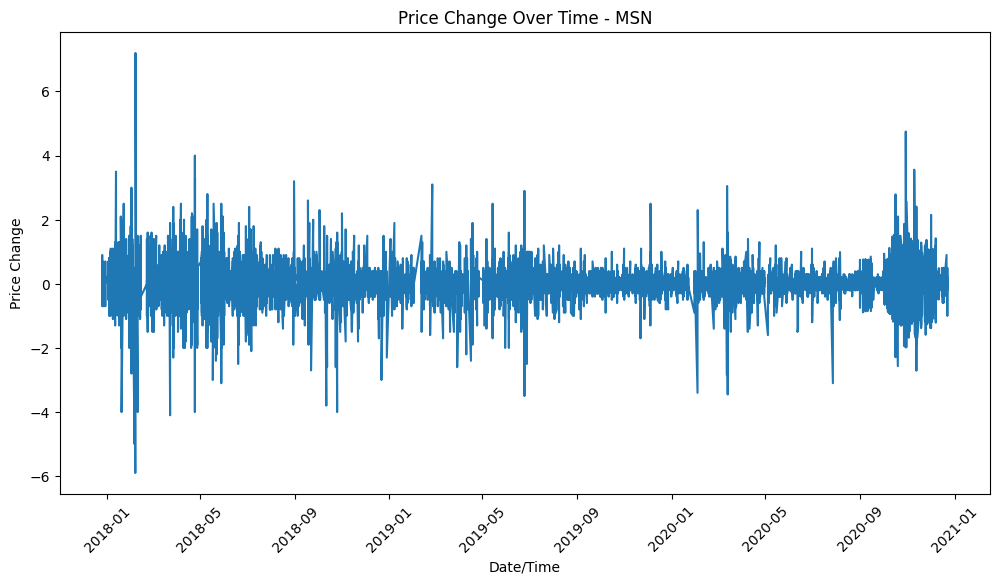

In [13]:

# Vẽ các biểu đồ cho từng mã cổ phiếu
for ticker in df['Ticker'].unique():
    df_ticker = df[df['Ticker'] == ticker]

    # Biểu đồ đường của giá trị thay đổi giá cổ phiếu theo thời gian
    plt.figure(figsize=(12, 6))
    plt.plot(df_ticker['Date/Time'], df_ticker['Price Change'])
    plt.title(f'Price Change Over Time - {ticker}')
    plt.xlabel('Date/Time')
    plt.ylabel('Price Change')
    plt.xticks(rotation=45)
    plt.show()


* ở phần này giá dao động của PNJ là dao động nhiều nhất 3 mã còn lại nhìn chung thì có FPT và MSN là ổn định

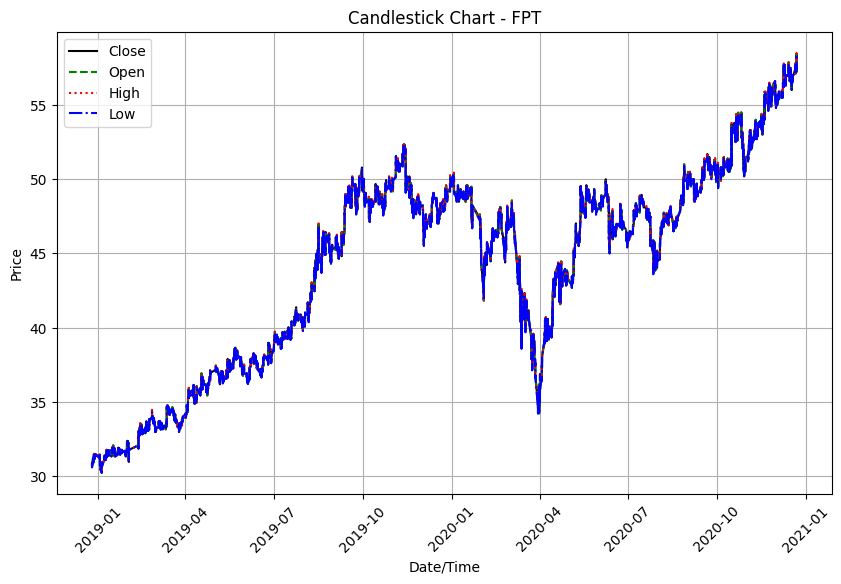

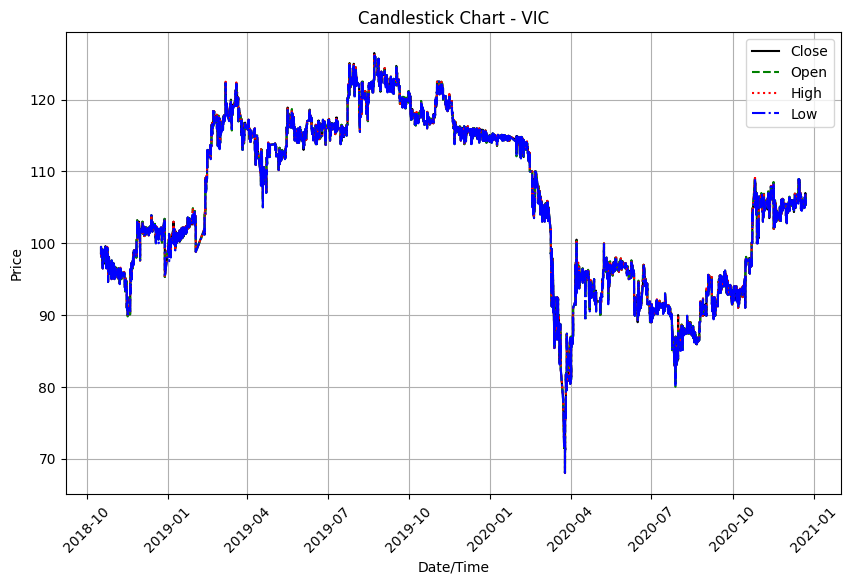

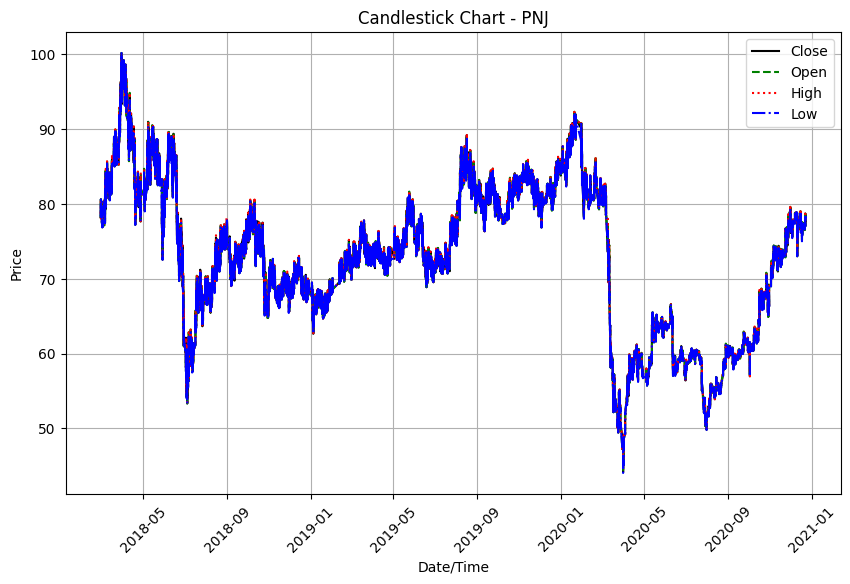

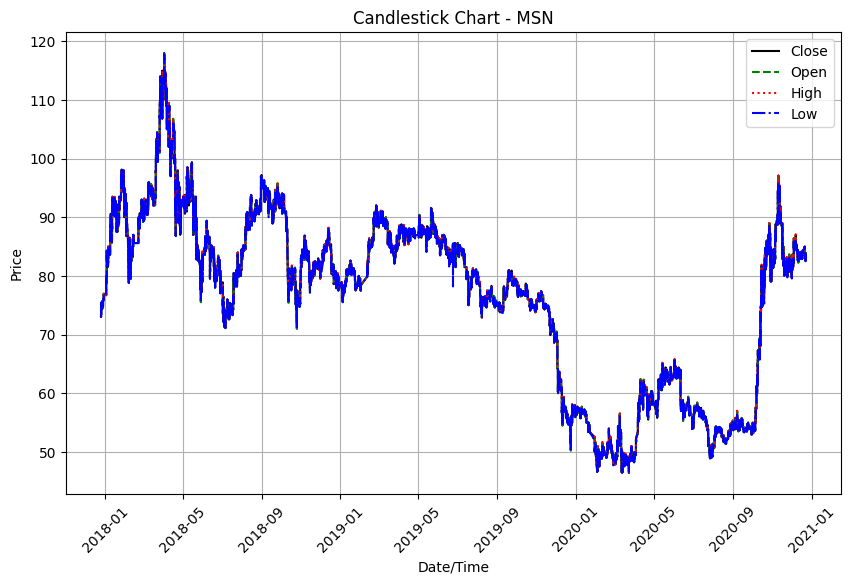

In [14]:
for ticker in df['Ticker'].unique():
    df_ticker = df[df['Ticker'] == ticker]

    # Vẽ biểu đồ candlestick
    plt.figure(figsize=(10, 6))
    plt.plot(df_ticker['Date/Time'], df_ticker['Close'], color='black', label='Close')
    plt.plot(df_ticker['Date/Time'], df_ticker['Open'], color='green', linestyle='--', label='Open')
    plt.plot(df_ticker['Date/Time'], df_ticker['High'], color='red', linestyle=':', label='High')
    plt.plot(df_ticker['Date/Time'], df_ticker['Low'], color='blue', linestyle='-.', label='Low')
    plt.title(f'Candlestick Chart - {ticker}')
    plt.xlabel('Date/Time')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

* tỷ số thay đổi giữa open close high và low là khong đáng kể xuyên xuốt qua các năm

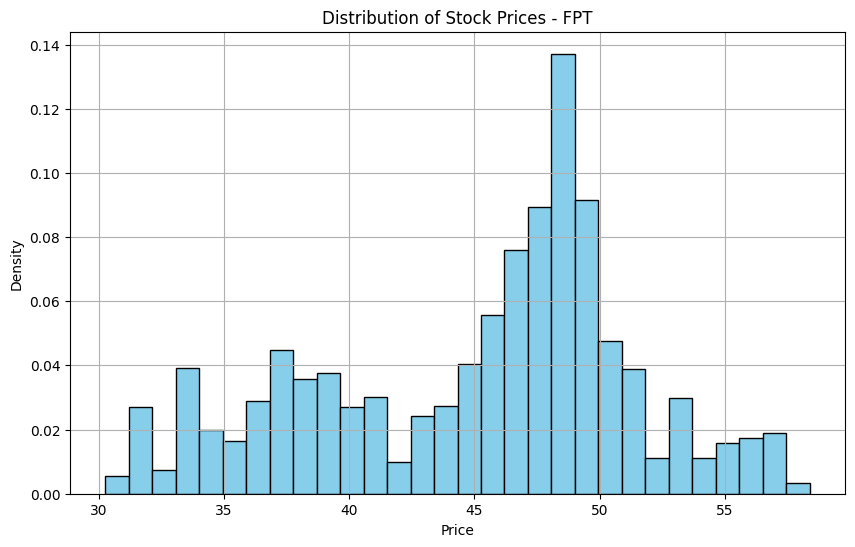

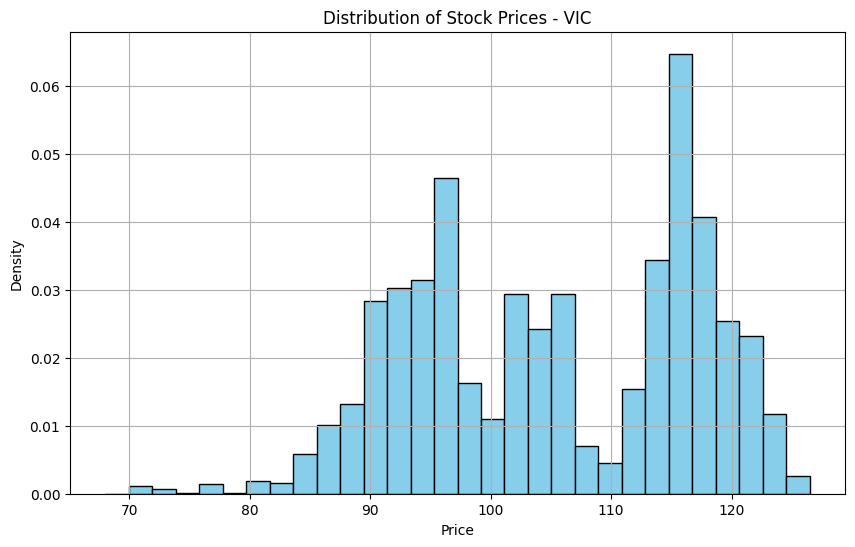

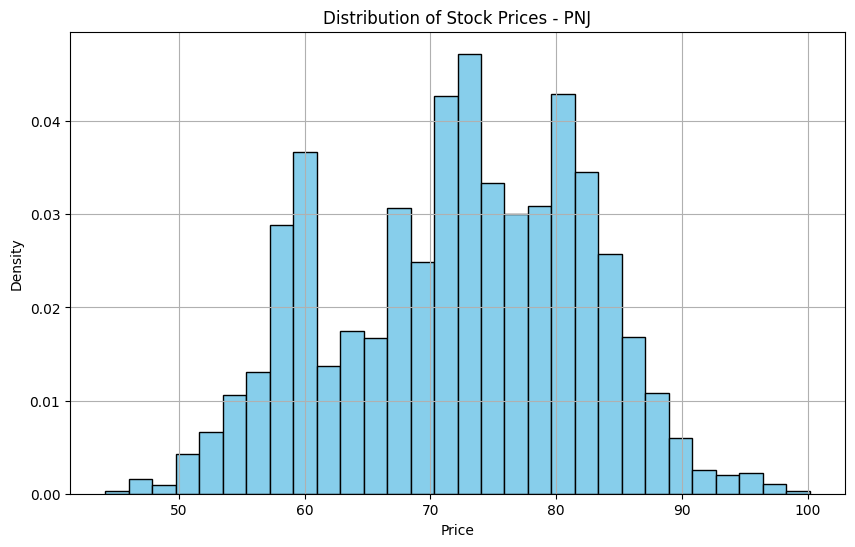

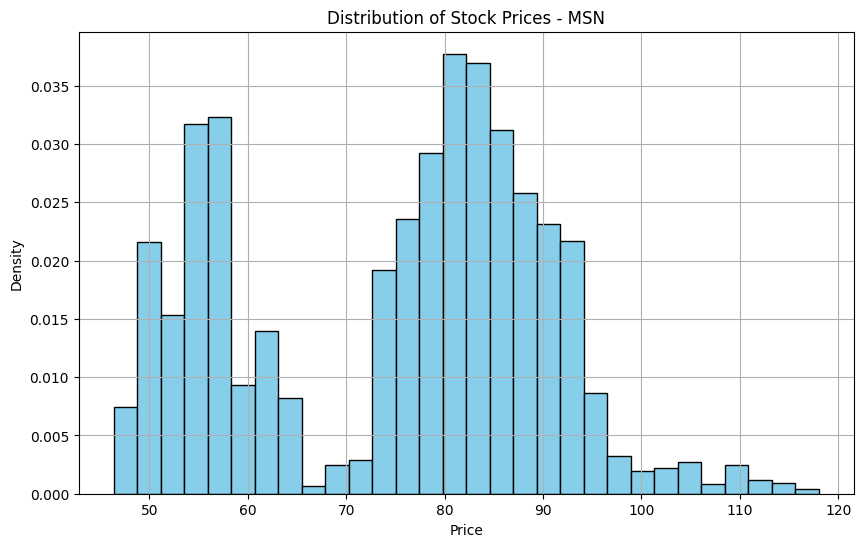

In [15]:
for ticker in df['Ticker'].unique():
    df_ticker = df[df['Ticker'] == ticker]

    # Biểu đồ phân phối của giá cổ phiếu
    plt.figure(figsize=(10, 6))
    plt.hist(df_ticker['Close'], bins=30, color='skyblue', edgecolor='black', density=True)
    plt.title(f'Distribution of Stock Prices - {ticker}')
    plt.xlabel('Price')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()


* cổ phiếu được mua nhiều nhất là FPT
* lượng mua nhiều và ổn định là PNJ
* VIC nhìn chung là giá khá cao nhưng lượng mua vào lại thấp 
* MSN có lượng mua vào là ít nhất và có giá trải dài từ thấp nhất đến cao nhất

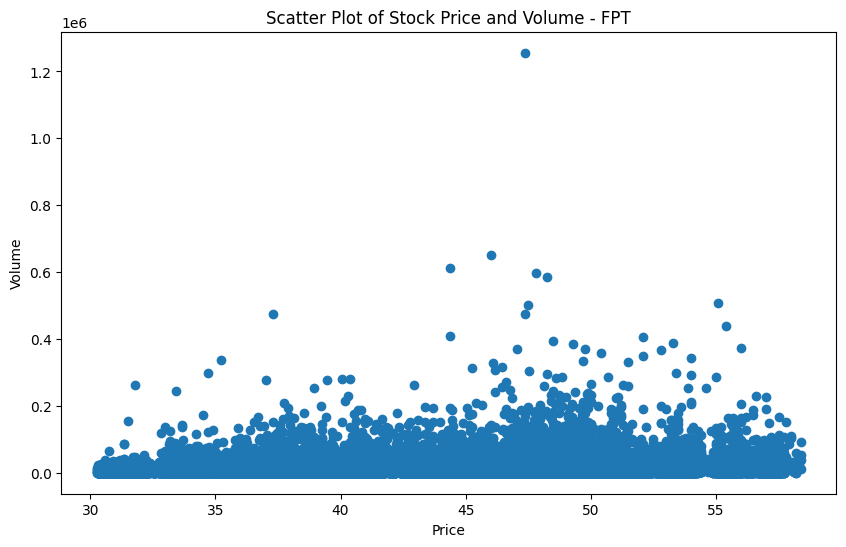

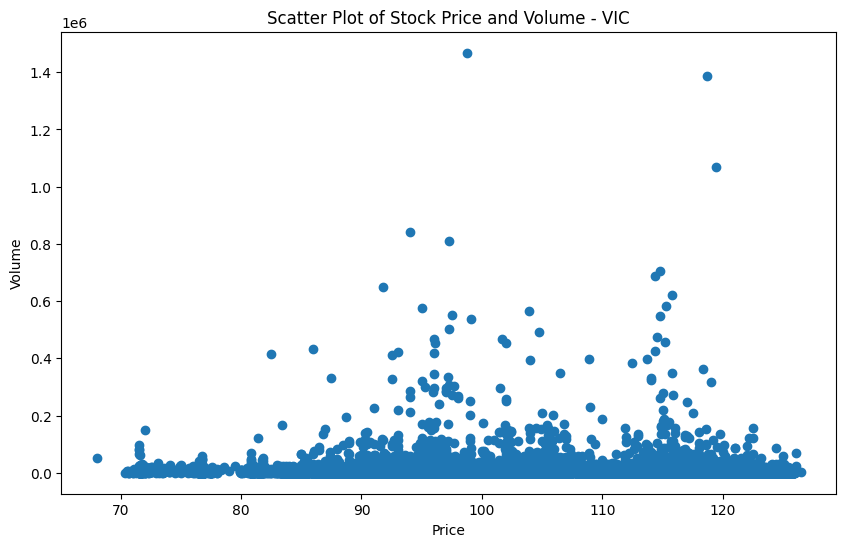

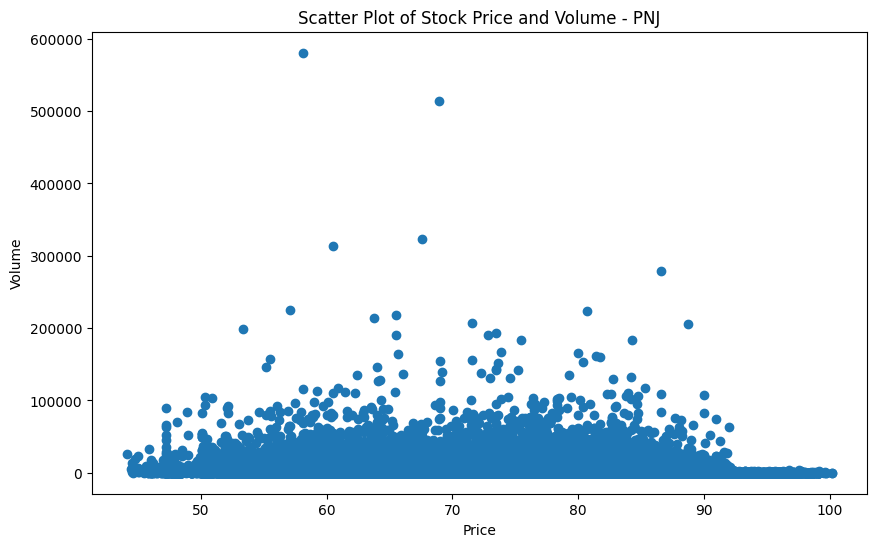

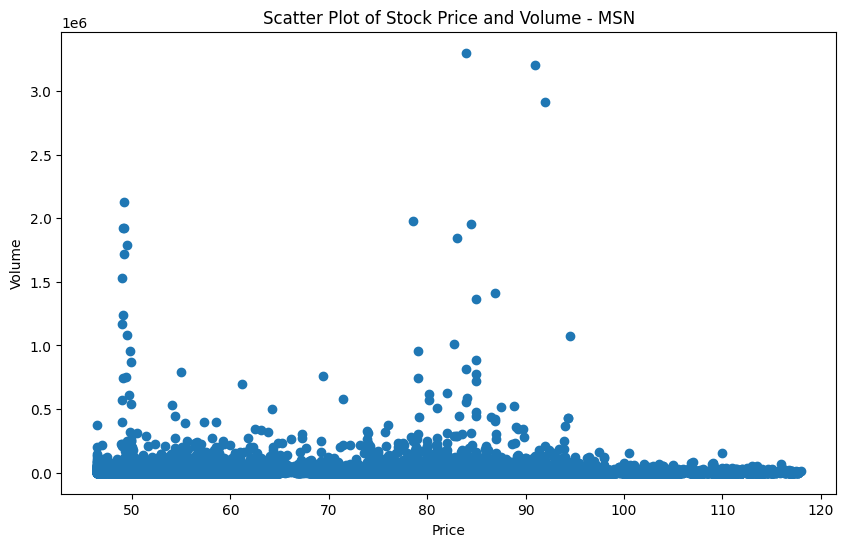

In [16]:
for ticker in df['Ticker'].unique():
    df_ticker = df[df['Ticker'] == ticker]
    plt.figure(figsize=(10, 6))
    plt.scatter(x=df_ticker['Close'], y=df_ticker['Volume'])
    plt.title(f'Scatter Plot of Stock Price and Volume - {ticker}')
    plt.xlabel('Price')
    plt.ylabel('Volume')
    plt.show()

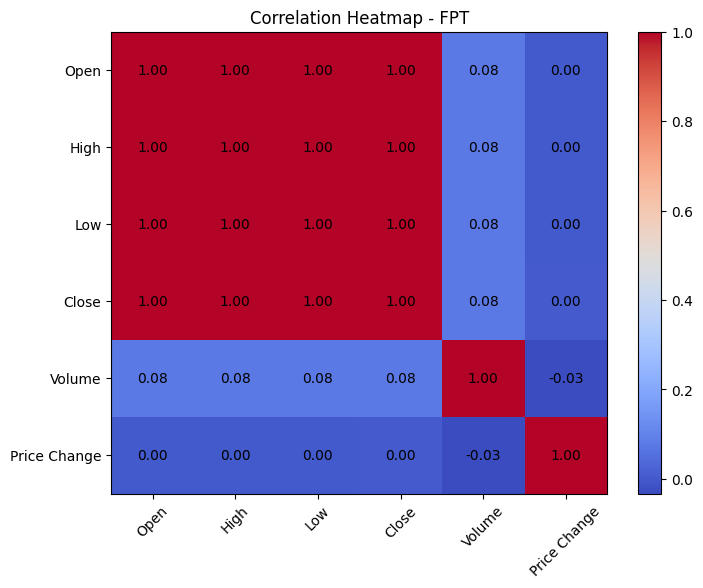

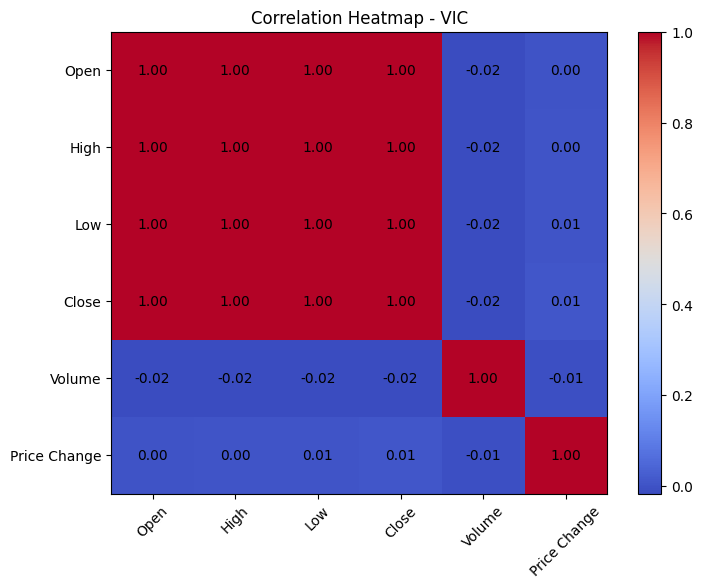

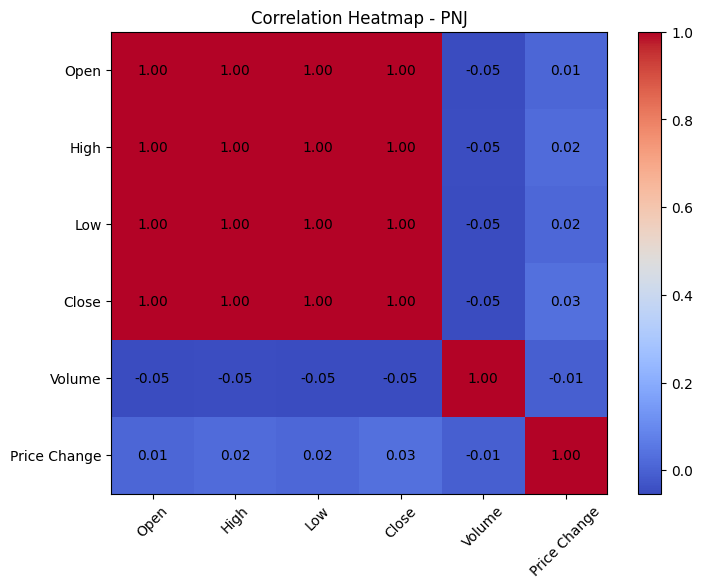

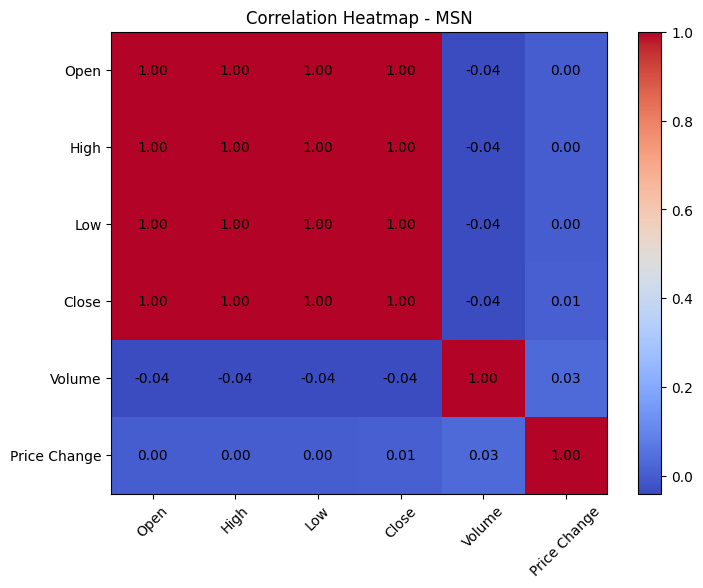

In [17]:
correlation_matrices = {}
for ticker in df['Ticker'].unique():
    df_ticker = df[df['Ticker'] == ticker]
    numeric_columns = df_ticker.select_dtypes(include=['float64', 'int64']).columns
    df_numeric = df_ticker[numeric_columns]
    correlation_matrix = df_numeric.corr()
    correlation_matrices[ticker] = correlation_matrix

# Vẽ heatmap cho từng mã cổ phiếu
for ticker, correlation_matrix in correlation_matrices.items():
    plt.figure(figsize=(8, 6))
    plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
    plt.colorbar()
    plt.title(f'Correlation Heatmap - {ticker}')
    plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
    plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
    
    for i in range(len(correlation_matrix.columns)):
        for j in range(len(correlation_matrix.columns)):
            plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')

    plt.show()

* các dữ liệu của các mã cổ phiếu khá tương đồng nên có thể gom lại để xây dựng chung 1 mô hình dự đoán

* Nhìn chung giá cổ phiếu không thay đổi quá nhiều từ lúc Open đến lúc Close cũng không quá cao cũng không tụt xuống quá thấp duy trì ở mức ổn định, chỉ có cổ phiếu của VIC giảm khá mạnh trong khoảng quý 2 năm 2022, còn lại nhìn chung là khá ổn định

In [18]:
threshold = 0

df['Label'] = np.where((df['Price Change'] <= threshold) & (df['Price Change'] >= -threshold), 1, 0)

In [19]:
df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Price Change,Label
0,FPT,2018-12-25 09:15:00,30.89,30.89,30.89,30.89,35410,0.00,1
1,FPT,2018-12-25 09:16:00,30.81,30.81,30.81,30.81,190,-0.08,0
2,FPT,2018-12-25 09:17:00,30.74,30.81,30.74,30.74,1120,-0.07,0
3,FPT,2018-12-25 09:18:00,30.74,30.74,30.74,30.74,2120,0.00,1
4,FPT,2018-12-25 09:19:00,30.74,30.74,30.74,30.74,22500,0.00,1


In [20]:
label_counts = df.groupby('Ticker')['Label'].value_counts()
label_counts

Ticker  Label
FPT     1        56888
        0        40518
MSN     1        69071
        0        66283
PNJ     0        68117
        1        57192
VIC     1        51945
        0        49321
Name: count, dtype: int64

* khối lượng dữ liệu khá cân bằng không cần thực hiện thêm cân bằng dữ liệu

## Modeling

Machine Learning Model

In [21]:

# Loại bỏ các hàng có giá trị thiếu trong cột Price Change
df.dropna(subset=['Price Change'], inplace=True)

# Xây dựng mô hình
X = df[['Open', 'High', 'Low', 'Volume']] 
y = df['Price Change'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)


Mean Squared Error: 0.14485259551067844


* Deep Learning Model được xây dựng bằng TensorFlow

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0066 - val_loss: 2.1751e-05
Epoch 2/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 1.9677e-05 - val_loss: 1.9803e-05
Epoch 3/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 1.6097e-05 - val_loss: 1.9065e-05
Epoch 4/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 1.5595e-05 - val_loss: 2.1255e-05
Epoch 5/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.7421e-05 - val_loss: 2.5242e-05
Epoch 6/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.7277e-05 - val_loss: 1.8183e-05
Epoch 7/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.7512e-05 - val_loss: 3.2646e-05
Epoch 8/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 2.0472e-05 - val_loss: 1.6702e-05
Epoch 9/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.8003e-05 - val_loss: 3.2137e-05
Epoch 10/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.7388e-05 - val_loss: 1.7560e-05
2871/2871 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 1.65

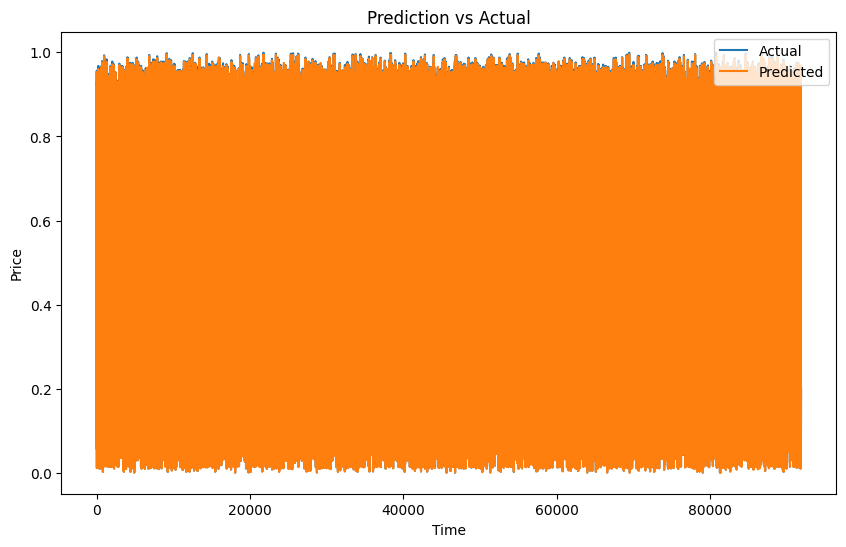

In [22]:


data = df[['Open', 'High', 'Low', 'Close', 'Volume']]

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Số lượng bước thời gian (timesteps) để dự đoán
n_steps = 60

X, y = [], []
for i in range(n_steps, len(data_scaled)):
    X.append(data_scaled[i - n_steps:i])
    y.append(data_scaled[i, 0])

X, y = np.array(X), np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#RNN
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(units=50, return_sequences=False),
    Dense(units=1)
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=10, batch_size=512, validation_data=(X_test, y_test), verbose=1)

loss = model.evaluate(X_test, y_test)
print(f'Loss on test set: {loss}')

y_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


* Kết hợp mô hình Deep Learning với mô hình Machine Learning 
** mô hình Deep Learning là CNN để trích xuất đặc trưng
** mô hình Machine Learning là XGB để dữ đoán lớp đầu ra

In [23]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

X_train_tensor = torch.tensor(X_scaled, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)

X_train, X_val, y_train, y_val = train_test_split(X_train_tensor, y_train_tensor, test_size=0.2, random_state=42)

X_train = X_train.transpose(1, 2)  # Transpose dimensions to [batch_size, channels, sequence_length]
X_val = X_val.transpose(1, 2) 

# CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=X_train.shape[1], out_channels=16, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3)
        self.fc1 = nn.Linear(in_features=32 * 13, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=1)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 13)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_cnn = CNN().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

from tqdm import tqdm

epochs = 10
batch_size = 512
for epoch in range(epochs):
    model_cnn.train()
    running_loss = 0.0
    tqdm_batch = tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch+1}/{epochs}", leave=False)
    for i in tqdm_batch:
        optimizer.zero_grad()
        inputs, labels = X_train[i:i+batch_size], y_train[i:i+batch_size]
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        outputs = model_cnn(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        tqdm_batch.set_postfix(loss=running_loss / ((i / batch_size) + 1))  # Update progress bar with current loss
    print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {running_loss / (len(X_train) / batch_size)}')

model_cnn.eval()
with torch.no_grad():
    y_train_pred = [model_cnn(inputs.unsqueeze(0)).squeeze().detach().cpu().numpy() for inputs in X_train]
    y_val_pred = [model_cnn(inputs.unsqueeze(0)).squeeze().detach().cpu().numpy() for inputs in X_val]

y_train_pred_2d = np.array(y_train_pred).reshape(-1, 1)
y_val_pred_2d = np.array(y_val_pred).reshape(-1, 1)


model_xgb = xgb.XGBRegressor()
model_xgb.fit(y_train_pred_2d, y_train.cpu().numpy())

y_val_pred_xgb = model_xgb.predict(y_val_pred_2d)
mse = mean_squared_error(y_val.cpu().numpy(), y_val_pred_xgb)
print(f'Mean Squared Error on validation set: {mse}')



Epoch [1/10], Average Loss: 0.0016371191700335034


Epoch [2/10], Average Loss: 7.275434995506992e-05


Epoch [3/10], Average Loss: 5.761938184097423e-05


Epoch [4/10], Average Loss: 5.2746509260479076e-05


Epoch [5/10], Average Loss: 4.4221880441785724e-05


Epoch [6/10], Average Loss: 4.300468387580554e-05


Epoch [7/10], Average Loss: 4.093894660215845e-05


Epoch [8/10], Average Loss: 3.920580413884805e-05


Epoch [9/10], Average Loss: 3.715449057846015e-05


Epoch [10/10], Average Loss: 3.569517987267997e-05
Mean Squared Error on validation set: 2.8087875762139447e-05


# nhìn chung mô hình kết hợp đưa ra chỉ số tốt nhất